
# Variational Autoencoder (VAE) on MNIST

This notebook implements a convolutional VAE that:
- Learns latent representations of MNIST digits
- Reconstructs input images
- Generates new digits from random latent vectors
- Visualizes interpolation between two latent points
- Compares performance for latent dimensions 128 vs 256


In [13]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class CFG:
    latent_dim = 128       # latent dimension (will test with 256 later)
    batch_size = 128
    lr = 1e-3
    epochs = 50
# --- Load MNIST dataset ---
# Each image is 1×28×28 grayscale digit (0–9)
transform = transforms.Compose([
    transforms.ToTensor()  # converts [0,255] → [0,1] tensor
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=CFG.batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=CFG.batch_size, shuffle=False)

print(f"Train images: {len(train_data)} | Test images: {len(test_data)}")


Train images: 60000 | Test images: 10000


In [18]:
# ============================================================
# Variational Autoencoder Model
# ============================================================
# Encoder:
#   - Convolutional layers extract features
#   - Flatten → two linear layers produce μ (mean) and log(σ²) (variance)
# Decoder:
#   - Starts from latent vector z → fully connected layer
#   - Transpose convolutions reconstruct the 28×28 image
# ============================================================

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        # --- Encoder ---
        # Input: 1×28×28
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),   # → 32×14×14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # → 64×7×7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # → 128×4×4
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # --- Decoder ---
        self.fc_dec = nn.Linear(latent_dim, 128*4*4)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),  # → 64×7×7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),                    # → 32×14×14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),                     # → 1×28×28
            nn.Sigmoid()                                            # output range [0,1]
        )

    def encode(self, x):
        """Encodes input into mean and log-variance vectors."""
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Applies the reparameterization trick: z = μ + σ * ε"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decodes latent vector back to an image of shape (1,28,28)."""
        h = self.fc_dec(z)
        h = h.view(-1, 128, 4, 4)
        out = self.dec(h)
        # Ensure output matches MNIST size exactly
        out = F.interpolate(out, size=(28, 28), mode='bilinear', align_corners=False)
        return out

    def forward(self, x):
        """Encodes → reparameterizes → decodes"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [19]:
# --- VAE loss function ---
# Total loss = Reconstruction loss + KL divergence
# Reconstruction term → how well decoder reproduces input
# KL term → encourages latent space to follow unit Gaussian

def vae_loss(recon, x, mu, logvar):
    # Binary cross-entropy loss for pixel reconstruction
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')

    # KL divergence between N(μ,σ²) and standard normal N(0,1)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl


In [20]:
# --- Training function ---
def train_vae(latent_dim):
    model = VAE(latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    history = []

    for epoch in range(1, CFG.epochs + 1):
        model.train()
        total_loss = 0
        for x, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{CFG.epochs}", leave=False):
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        history.append(avg_loss)
        print(f"Epoch {epoch:02d}/{CFG.epochs} | Avg Loss: {avg_loss:.4f}")

    return model, history


In [21]:
# --- Train VAE with latent dimension = 128 ---
model_128, hist_128 = train_vae(CFG.latent_dim)

Epoch 01/50 | Avg Loss: 171.7799


Epoch 02/50 | Avg Loss: 115.5692


Epoch 03/50 | Avg Loss: 108.5901


Epoch 04/50 | Avg Loss: 106.1900


Epoch 05/50 | Avg Loss: 104.8328


Epoch 06/50 | Avg Loss: 103.7946


Epoch 07/50 | Avg Loss: 103.1935


Epoch 08/50 | Avg Loss: 102.6241


Epoch 09/50 | Avg Loss: 102.0788


Epoch 10/50 | Avg Loss: 101.6484


Epoch 11/50 | Avg Loss: 101.3213


Epoch 12/50 | Avg Loss: 101.0527


Epoch 13/50 | Avg Loss: 100.7729


Epoch 14/50 | Avg Loss: 100.5256


Epoch 15/50 | Avg Loss: 100.2770


Epoch 16/50 | Avg Loss: 100.0901


Epoch 17/50 | Avg Loss: 99.8510


Epoch 18/50 | Avg Loss: 99.6649


Epoch 19/50 | Avg Loss: 99.4928


Epoch 20/50 | Avg Loss: 99.3050


Epoch 21/50 | Avg Loss: 99.1720


Epoch 22/50 | Avg Loss: 99.0556


Epoch 23/50 | Avg Loss: 98.9047


Epoch 24/50 | Avg Loss: 98.7882


Epoch 25/50 | Avg Loss: 98.6399


Epoch 26/50 | Avg Loss: 98.4864


Epoch 27/50 | Avg Loss: 98.4075


Epoch 28/50 | Avg Loss: 98.3495


Epoch 29/50 | Avg Loss: 98.2422


Epoch 30/50 | Avg Loss: 98.1671


Epoch 31/50 | Avg Loss: 98.0186


Epoch 32/50 | Avg Loss: 98.0002


Epoch 33/50 | Avg Loss: 97.8937


Epoch 34/50 | Avg Loss: 97.8354


Epoch 35/50 | Avg Loss: 97.7605


Epoch 36/50 | Avg Loss: 97.6491


Epoch 37/50 | Avg Loss: 97.6132


Epoch 38/50 | Avg Loss: 97.5242


Epoch 39/50 | Avg Loss: 97.4391


Epoch 40/50 | Avg Loss: 97.4046


Epoch 41/50 | Avg Loss: 97.2990


Epoch 42/50 | Avg Loss: 97.2910


Epoch 43/50 | Avg Loss: 97.2127


Epoch 44/50 | Avg Loss: 97.1991


Epoch 45/50 | Avg Loss: 97.1157


Epoch 46/50 | Avg Loss: 97.0712


Epoch 47/50 | Avg Loss: 97.0487


Epoch 48/50 | Avg Loss: 96.9423


Epoch 49/50 | Avg Loss: 96.9189


Epoch 50/50 | Avg Loss: 96.8914


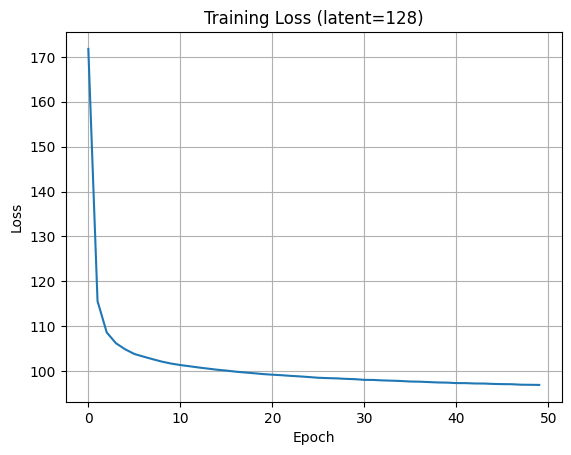

In [22]:
# --- Plot training curve ---
plt.plot(hist_128)
plt.title("Training Loss (latent=128)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

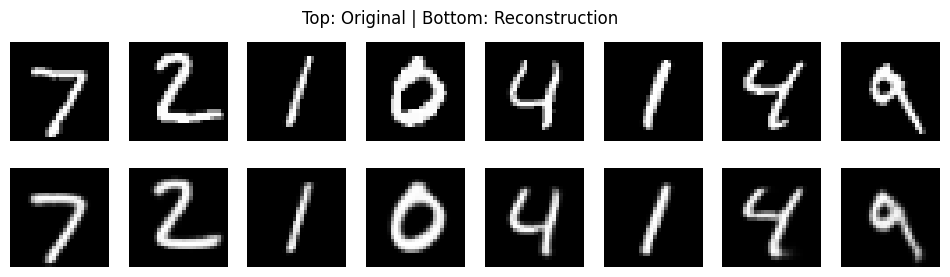

In [23]:
# --- Reconstruction visualization ---
# Compare original MNIST digits vs. their reconstructions
model_128.eval()
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    recon, _, _ = model_128(x)

x = x.cpu().numpy()[:8]
recon = recon.cpu().numpy()[:8]

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(x[i, 0], cmap='gray'); axes[0, i].axis('off')
    axes[1, i].imshow(recon[i, 0], cmap='gray'); axes[1, i].axis('off')
plt.suptitle("Top: Original | Bottom: Reconstruction")
plt.show()

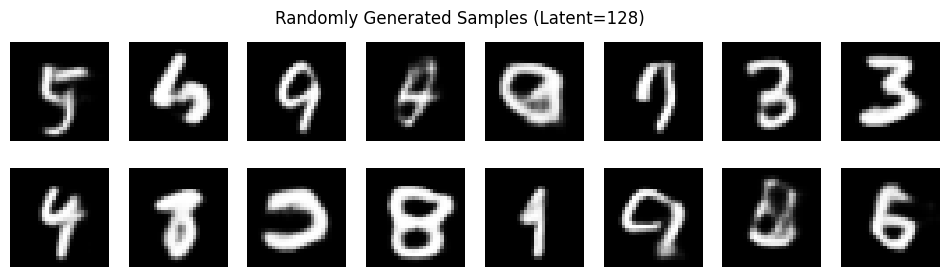

In [24]:
# --- Random sampling ---
# Generate completely new digits from random latent vectors
with torch.no_grad():
    z = torch.randn(16, CFG.latent_dim).to(device)
    samples = model_128.decode(z).cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    axes[i//8, i%8].imshow(samples[i, 0], cmap='gray'); axes[i//8, i%8].axis('off')
plt.suptitle("Randomly Generated Samples (Latent=128)")
plt.show()

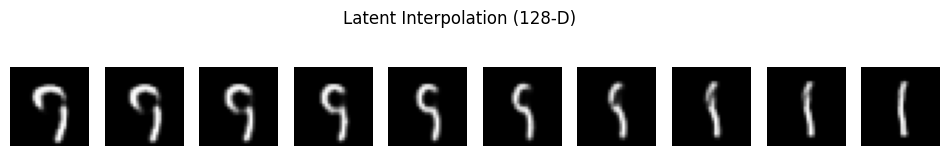

In [25]:
# --- Latent interpolation ---
# Smoothly move between two latent vectors and visualize transition
def interpolate(z1, z2, steps=10):
    alphas = np.linspace(0, 1, steps)
    return torch.stack([(1 - a) * z1 + a * z2 for a in alphas])

with torch.no_grad():
    z1 = torch.randn(1, CFG.latent_dim).to(device)
    z2 = torch.randn(1, CFG.latent_dim).to(device)
    zs = interpolate(z1, z2, steps=10).squeeze(1)
    imgs = model_128.decode(zs).cpu().numpy()

fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for i in range(10):
    axes[i].imshow(imgs[i, 0], cmap='gray'); axes[i].axis('off')
plt.suptitle("Latent Interpolation (128-D)")
plt.show()

In [ ]:
# --- Retrain with latent dimension = 256 ---
# Larger latent space → potentially richer representations, smoother samples
model_256, hist_256 = train_vae(256)

Epoch 01/50 | Avg Loss: 175.0140


Epoch 02/50 | Avg Loss: 119.7119


Epoch 03/50 | Avg Loss: 110.5095


Epoch 04/50 | Avg Loss: 107.5803


Epoch 05/50 | Avg Loss: 105.8824


Epoch 06/50 | Avg Loss: 104.8136


Epoch 07/50 | Avg Loss: 103.9265


Epoch 08/50 | Avg Loss: 103.2272


Epoch 09/50 | Avg Loss: 102.6718


Epoch 10/50 | Avg Loss: 102.2507


Epoch 11/50 | Avg Loss: 101.8646


Epoch 12/50:  95%|█████████▍| 445/469 [00:11<00:00, 37.60it/s]

In [ ]:
# --- Compare random samples for 256-D latent space ---
with torch.no_grad():
    z = torch.randn(16, 256).to(device)
    samples_256 = model_256.decode(z).cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    axes[i//8, i%8].imshow(samples_256[i, 0], cmap='gray'); axes[i//8, i%8].axis('off')
plt.suptitle("Random Samples (Latent Dim = 256)")
plt.show()

In [ ]:
# --- Latent Space Grid Visualization ---
def plot_latent_grid(model, n=20, grid_range=3):
    """Generates an n×n grid of decoded images from 2D latent space."""
    grid_x = np.linspace(-grid_range, grid_range, n)
    grid_y = np.linspace(-grid_range, grid_range, n)
    
    canvas = np.zeros((28*n, 28*n))
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                x_decoded = model.decode(z)
                digit = x_decoded[0, 0].cpu().numpy()
                canvas[i*28:(i+1)*28, j*28:(j+1)*28] = digit

    plt.figure(figsize=(8, 8))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.title("2D Latent Space Grid of Generated Digits")
    plt.show()

# Example (requires latent_dim=2 model):
# plot_latent_grid(model_2d)
